# **2020732022 김보민**
## 인공지능 응용 
## assignment 11
---

## **Assignment**
## **다음 미완성 코드를 활용해 새로운 data를 학습해보자**
* Training data image 
  + Shape: (?, 3, 64, 128)
    - 여러장의, RGB, 64x128 size의 이미지라고 가정하자
* Test data image
  + Shape: (?, 3, ?, ?)
    - 여러장의, RGB, size를 알 수 없는 이미지라고 가정하자
* Labels
  + image의 class는 2가지 이다
  + data folder의 구성을 참고하자
* Data folder 위치
  + 노트북 github의 data folder 2개를 적당한 위치에 카피해 사용한다

In [3]:
# import
import torch   # torch import
import torch.cuda as cuda # GPU
import torch.nn as nn  # torch.nn import
import torch.nn.functional as F  # pytorch 함수 import
import torch.optim as optim   # optimizer import

from torch.utils.data import DataLoader, Dataset  # 데이터 로딩
from torchvision import transforms, datasets     # 데이터 변환
from torchvision.datasets import ImageFolder     # torchvision.dataset의 데이터 불럭오기

# cuda(device), seed 선언
device = 'cuda' if cuda.is_available() else 'cpu' # GPU 사용시 cuda, CPU 사용시 cpu 출력
print(device)

torch.manual_seed(1)  # 시드 고정
if device=='cuda':    # GPU 사용 가능일 경우 랜덤 시드 고정
    torch.cuda.manual_seed_all(1)

from google.colab import drive  # 구글 드라이브 import
drive.mount('/content/drive') # 구글 드라이브 mount

# dataset 불러오기
# 사용자 정의 데이터셋
class data(Dataset):   # imagefoler 사용 : 계층적인 데이터셋
    def __init__(self, path, transfer):  # Dataset 객체가 생성될 때 한 번만 실행
        data = ImageFolder(root=path, transform=transfer)  # path : 데이터 위치
        self.imgs = []  # 빈 배열 imgs 
        self.labels = []   # 빈 배열 labels

        for i, (img, label) in enumerate(data):
            self.imgs.append(img)
            self.labels.append([label])

        self.length = len(self.labels)  # 데이터 샘플 길이
    
    def __len__(self):     # 데이터셋의 샘플 개수를 반환
        return self.length
    
    def __getitem__(self, item):   #주어진 인덱스 (item) 에 해당하는 샘플을 데이터셋에서 불러오고 반환
        data = self.imgs[item]
        target = torch.Tensor(self.labels[item]).to(torch.long).squeeze()
        return data, target


# 사이즈 조절
transferF = Compose([Resize([64, 128]), RandomCrop([64, 128]), ToTensor()])
transferFte = Compose([Resize([64, 128]), ToTensor()])

train_dataset = data('/content/drive/MyDrive/test_data', transferF)   # [64, 128]로 사이즈 조절한 데이터를 train dataset에 저장

train_loader = torch.utils.data.DataLoader(data=train_dataset,   # 데이터 로드, 배치사이즈 15, 셔플
                                           batch_size=15,
                                           shuffle=True,)

test_dataset = dataset('/content/drive/MyDrive/train_data', transferFte)   # [64, 128]로 사이즈 조절한 데이터를 test dataset에 저장
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,   # 데이터 로드, 배치사이즈 15, 셔플
                                           batch_size=15,
                                           shuffle=True)

# 모델 선언
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.imagesize = (64,128,3)

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)     # 10,64,128
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)    #  20,64,128
        self.mp1 = nn.MaxPool2d(2)                                  # 20,16,32

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 20,8,16
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # 20,4,8
        self.mp2 = nn.MaxPool2d(2)                                  # 20,16,32

        self.fc1 = nn.Linear(256 * 4 * 8, 512)  # 전결합층
        self.fc2 = nn.Linear(512, 2)


    def forward(self, x):     # 활성화 함수 relu
        in_size = x.size(0)

        x = F.relu(self.mp1(self.conv1(x)))
        x = F.relu(self.mp1(self.conv2(x)))

        x = F.relu(self.mp1(self.conv3(x)))
        x = F.relu(self.mp2(self.conv4(x)))

        x = x.view(in_size, -1)  # 텐서 1차원으로 펼치기
        x = self.fc1(x)
        x = self.fc2(x)          

        return x


# 파라미터, 손실함수 설정
model = Net()
model = model.to(device)
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.00015)  # learning rate 0.00015
Best = -1

for epoch in range(1, 11):   # 10 번 반복 (1~10)
  
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)   # device : gpu 
        target = target.to(device)
        output = model(data)   # 모델의 출력값을 output에 저장
        loss = criterion(output, target)   # 오차 계산
        train_loss += loss

        optimizer.zero_grad()  # 모델 최적화
        loss.backward()
        optimizer.step()
    with torch.no_grad():
      test_loss = 0
      correct = 0
      
      for data, target in test_loader:
          data = data.to(device)
          target = target.to(device)
          output = model(data)
          test_loss += criterion(output, target).item()
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()

      acc = 100. * correct / len(test_loader.dataset)    # 정확도 계산
      if acc > Best:
          Best = acc
          

      # 결과 출력
      print('\nTrain set {} Epoch: loss: {:.8f}'.format(epoch, loss))  
      print('\nTest set:  Accuracy: {}/{} ({:.0f}%), Best Accuracy {:.0f}%\n'.format(
           correct, len(test_loader.dataset), acc, Best))
      print('=='*100)

cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Train set 1 Epoch: loss: 0.70693988

Test set:  Accuracy: 328/551 (60%), Best Accuracy 60%


Train set 2 Epoch: loss: 0.66810286

Test set:  Accuracy: 328/551 (60%), Best Accuracy 60%


Train set 3 Epoch: loss: 0.71342456

Test set:  Accuracy: 328/551 (60%), Best Accuracy 60%


Train set 4 Epoch: loss: 0.59594095

Test set:  Accuracy: 328/551 (60%), Best Accuracy 60%


Train set 5 Epoch: loss: 0.66182804

Test set:  Accuracy: 328/551 (60%), Best Accuracy 60%


Train set 6 Epoch: loss: 0.64291966

Test set:  Accuracy: 328/551 (60%), Best Accuracy 60%


Train set 7 Epoch: loss: 0.71011162

Test set:  Accuracy: 328/551 (60%), Best Accuracy 60%


Train set 8 Epoch: loss: 0.68860382

Test set:  Accuracy: 328/551 (60%), Best Accuracy 60%


Train set 9 Epoch: loss: 0.59539330

Test set:  Accuracy: 328/551 (60%), Best Accuracy 60%


Train set 10 Epoch: loss: 0.

#MNIST

cuda


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw

Learning started. It takes sometime.
[Epoch:    1] cost = 0.225649118
[Epoch:    2] cost = 0.0630326271
[Epoch:    3] cost = 0.0462854579
[Epoch:    4] cost = 0.0374419205
[Epoch:    5] cost = 0.0313408412
[Epoch:    6] cost = 0.0261345636
[Epoch:    7] cost = 0.0217328668
[Epoch:    8] cost = 0.0184135064
[Epoch:    9] cost = 0.0158244334
[Epoch:   10] cost = 0.0130685065
[Epoch:   11] cost = 0.0100885527
[Epoch:   12] cost = 0.00990540907
[Epoch:   13] cost = 0.00871057063
[Epoch:   14] cost = 0.00720665278
[Epoch:   15] cost = 0.00579965673
Learning Finished!
Accuracy: 0.9847999811172485
Label:  2
Prediction:  2


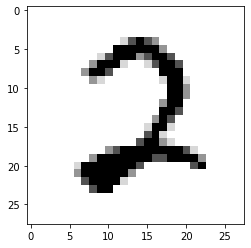

In [ ]:
# import
import torch   # torch import
import torch.cuda as cuda # GPU
import torch.nn as nn  # torch.nn import
import torch.nn.functional as F  # pytorch 함수 import
import torch.optim as optim   # optimizer import

from torch.utils.data import DataLoader, Dataset  # 데이터 로딩
from torchvision import transforms, datasets     # 데이터 변환
from torchvision.datasets import ImageFolder     # torchvision.dataset의 데이터 불럭오기

import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)   # GPU 사용시 cuda, CPU 사용시 cpu 출력

# for reproducibility
torch.manual_seed(777) 
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,                      # trian data 
                          transform=transforms.ToTensor(), # 데이터 형태 tensor 로 받아옴
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,                      # test data 
                         transform=transforms.ToTensor(),  # 데이터 형태 tensor 로 받아옴
                         download=True)

# dataset loader
batch_size = 100      # batch 사이즈 설정
data_loader = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)   # drop last를 True로 설정 : 남는 batch는 버리기

# CNN model
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = torch.nn.Linear(64*7*7, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # 1차원 텐서로 펼치기
        out = self.fc(out)
        return out

# 학습하기
# parameters
learning_rate = 0.001
training_epochs = 15

# contruct model
model = CNN().to(device)

# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train
total_batch = len(data_loader)   # 위에서 batch size = 100 으로 설정, 즉 data loader의 길이
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:    # data loader 에서 꺼내서 학습
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

print('Learning Finished!')

# 모델 성능 테스트
# Test model and check accuracy
with torch.no_grad():
    X_test = mnist_test.data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.targets.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test      # Y test 데이터와 모뎉에 X test 데이터를 넣은 출력값을 비교: 같으면 1 출력
    accuracy = correct_prediction.float().mean()   # 맞은것 (출력된 1)의 갯수를 전체의 갯수로 나눔
    print('Accuracy:', accuracy.item())

# Random sample test
with torch.no_grad():
  r = random.randint(0, len(mnist_test) - 1)
  img_sample = mnist_test.data[r].view(1, 1, 28, 28).float().to(device)
  label_sample = mnist_test.targets[r].to(device)

  print('Label: ', label_sample.item())
  sample_prediction = model(img_sample)
  print('Prediction: ', torch.argmax(sample_prediction, axis=1).item())

  plt.imshow(mnist_test.data[r].view(28, 28), cmap='Greys', interpolation='nearest')
  plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')